Firstly, import the fortran disk model routines and the python likelihood functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from diskfit import profilecirc
from diskfit import likelihood, utils
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
from diskfit import likelihood, utils
from scipy.optimize import minimize

%matplotlib inline
import os,sys
import matplotlib
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import csv
import pandas as pd
import sfdmap
import extinction
from astropy import units as u
import math
import pylatex

# pyqsofit
from scipy import interpolate

# for SDSS SQL queries
#import mechanize
#from io import BytesIO

import glob,timeit

#sys.path.append('/Users/runnojc1/Software/py/pyspeckit')
import pyspeckit
from pyspeckit.spectrum.models.inherited_gaussfitter import gaussian
from pyspeckit.specwarnings import PyspeckitWarning
from astropy.table import Table

import tqdm

import warnings
from astropy.units import UnitsWarning

Load the continuum subtracted spectrum. Establish the redshift and narrow line width in Angstroms. 

In [2]:
def kms_to_ang(dv,w0):
    """
    Convert a width in km/s to A.
    """
    c = 2.99792458e5 # km/s
    dlam = (dv/c)*w0
    return dlam

In [3]:
def gaussian(xarr,amplitude,cent,fwhm,normalized=False,return_components=False,return_hyperfine_components=False):
    """
    Returns a 1-dimensional gaussian of form
    A*np.exp(-(x-dx)**2/(2*w**2))

    Area is sqrt(2*pi*sigma^2)*amplitude - i.e., this is NOT a normalized
    gaussian, unless normalized=True in which case A = Area
    
    Parameters
    ----------
    xarr : np.ndarray
        array of x values
    amplitude : float
        Amplitude of the Gaussian, i.e. its peak value, unless
        normalized=True then A is the area of the gaussian
    cent : float
        Center or "shift" of the gaussian same units as xarr
    fwhm : float
        Full width at half maximum of the Gaussian in km/s
    return_components : bool
        dummy variable; return_components does nothing but is required by all
        fitters
    return_hyperfine_components : bool
        dummy variable; does nothing but is required by all
        fitters
    normalized : bool
        Return a normalized Gaussian?
    """ 
    fwhm = kms_to_ang(fwhm,cent)
    if fwhm == 0:
        return np.nan
    elif fwhm < 0:
        warnings.warn("Negative width in Gaussian: {0}.".format(fwhm),
                      PyspeckitWarning)

    width = fwhm/np.sqrt(8*np.log(2))
    xarr = np.array(xarr) # make sure xarr is no longer a spectroscopic axis
    model = amplitude*np.exp(-(xarr-cent)**2/(2.0*width**2))
    if normalized:
        return model / (np.sqrt(2*np.pi) * width**2)
    else:
        return model

In [4]:
def powerlaw(x, scale, power):
    """
    Defines a power law

    Returns
    -------
    scale * x**power
    """
    return scale*(x/1000.)**-power

In [5]:
def template_fitter(wave,templates,scale_factor,index,shift):
    '''
    given a series of templates (like stellar models by age or Fe II templates by convolution width),
    returns a spectrum interpolated between template spectra and scaled.
    Spectrum is also interpolated onto the wavelength vector of the observed data.
    
    params:
        wave - wavelength vector of observed data
        templates - 2D numpy array of shape (numpoints,num_templates+1), where 1st column is wavelength, subsequent columns are templates
        index - selected index within templates [0-num_templates]. Float, will interpolate between templates when index!=int
        scale_factor - multiplicative scale factor for spectrum
    '''
    num_templates=templates.shape[1]-1
    numpoints=templates.shape[0]
    
    if shift>=0:
        wave_temp=templates[:,0]*(1+shift)
    else:
        wave_temp=templates[:,0]/(1+shift)
    flux_temp=templates[:,1:]
    
    # Perform interpolation between templates
    if index==num_templates-1:
        spectrum=templates[:,-1]
    else:
        lower_idx=int(math.floor(index)+1) #+1 because 0th index is wavelength column
        lower_spectrum=templates[:,lower_idx] # this means lower in index, not necessarily in flux
        
        upper_idx=lower_idx+1
        upper_spectrum=templates[:,upper_idx]
        
        weight=(index+1)-lower_idx #1=choose upper spectrum value, 0=choose lower spectrum value, 0.5=choose midpoint
        
        distances=upper_spectrum-lower_spectrum # array of distances between selected spectra
        
        spectrum=lower_spectrum+(weight*distances)
        
    # Perform scaling
    scaled_spectrum=spectrum*scale_factor
    
    # interpolate spectrum onto wavelength vector of data
    final_spectrum=np.interp(wave,wave_temp,scaled_spectrum)

    return final_spectrum

In [6]:
SII1_F0 = 11.1721073
SII1_CENT0 = 6716.04314
SII1_FWHM0 = 393.5954679
SII2_F0 = 8.335673742
SII2_CENT0 = 6730.906927
SII2_FWHM0 = 393.5954679
NII1_F0 = 10.63741401
NII1_CENT0 = 6548.323235
NII1_FWHM0 = 393.5954679
NII2_F0 = 31.52318712
NII2_CENT0 = 6582.888789
NII2_FWHM0 = 393.5954679 
HALPHA1_F0 = 20.63047916
HALPHA1_CENT0 = 6562.187441
HALPHA1_FWHM0 = 393.5954679

OI1_F0 = 7.998443445  
OI1_CENT0 = 6300.416844  
OI1_FWHM0 = 393.5954679  
OI2_F0 = 2.666147815  
OI2_CENT0 = 6367.798683  
OI2_FWHM0 = 393.5954679 

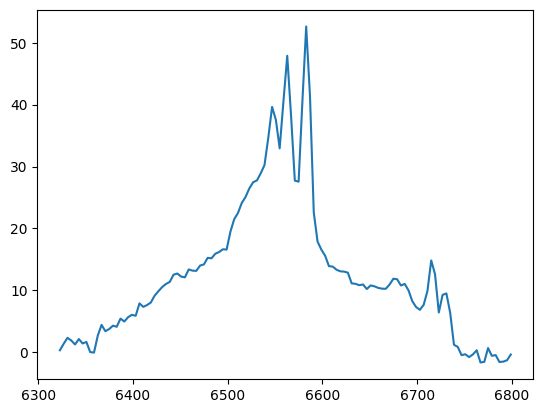

In [7]:
file_name = '/home/serat/Downloads/ticktock/bundle_20230529_standards/spectrum_20230112_0000010_exp01_red.fits'
hdul = fits.open(file_name)
data = hdul[0].data
hdr = hdul[0].header

z = 0.081

wl = data[0]
flux = data[1] * (10**16)
err = data[2]


wl = wl / (1 + z)


mask0 = np.where((wl > 6000) & (wl < 7500))
wl_o = wl[mask0]
flux_o = flux[mask0]
err_o = err[mask0]


mask1 = np.where((wl_o < 6015) | (wl_o > 6170))
wl = wl_o[mask1]
flux = flux_o[mask1]
err = err_o[mask1]

mask2 = np.where((wl < 6340) | (wl > 6445))
wl = wl[mask2]
flux = flux[mask2]
err = err[mask2]

mask3 = np.where((wl < 6455) | (wl > 6800))
wl = wl[mask3]
flux = flux[mask3]
err = err[mask3]

mask4 = np.where((wl < 7000) | (wl > 7130))
wl = wl[mask4]
flux = flux[mask4]
err = err[mask4]


coefficients = np.polyfit(wl, flux, 3)
polynomial = np.poly1d(coefficients)
fitted_continuum = polynomial(wl_o)

degree = 3

coefficients = np.polyfit(wl, flux, degree)
polynomial_continuum = np.poly1d(coefficients)(wl_o)
standard_flux = flux_o / polynomial_continuum
standard_wl = wl_o

file_path = '/home/serat/Downloads/ticktock/HET/combined_spectrum_20230113_0000022_exp01.fits'

t = Table.read(file_path)
t.sort('Wavelength')

z = 0.081
wl = t['Wavelength']/(1+z)
flux = t['F_lambda'] * (10**17)
err = t['e_F_lambda'] * (10**17)

flux_lim = np.where(flux>0)[0]
source_wl=wl[flux_lim]
source_flux=flux[flux_lim]
source_err=err[flux_lim]

wl_lim = np.where((source_wl>6320)&(source_wl<6800))
source_wl=source_wl[wl_lim]
source_flux=source_flux[wl_lim]
source_err=source_err[wl_lim]

shift = 0
scale = 1.18

tmp = standard_flux

standard_wl = standard_wl + shift
tmp = (1-(1-tmp)**scale)
inf = np.where(np.isfinite(tmp) == False)[0]

standard_flux[inf] = 1
standard_flux = (1-(1-standard_flux)**scale)

mask1 = np.where(standard_wl < 6340)[0]
mask2 = np.where((standard_wl > 6445) & (standard_wl < 6455))[0]
mask3 = np.where((standard_wl > 6800) & (standard_wl < 7010))[0]
mask4 = np.where(standard_wl > 7130)[0]

standard_flux[mask1] = 1
standard_flux[mask2] = 1
standard_flux[mask3] = 1
standard_flux[mask4] = 1



bin_size = 4
bins = np.arange(start=min(np.min(source_wl), np.min(standard_wl)), stop=max(np.max(source_wl), np.max(standard_wl)) + bin_size, step=bin_size)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
wavelength = bin_centers


indices1 = np.digitize(source_wl, bins) - 1
indices2 = np.digitize(standard_wl, bins) - 1
source_flux = np.array([np.mean(source_flux[indices1 == i]) for i in range(len(bin_centers))])
standard_flux = np.array([np.mean(standard_flux[indices2 == i]) for i in range(len(bin_centers))])
binned_err = np.array([np.mean(source_err[indices1 == i]) for i in range(len(bin_centers))])


flux_halpha = source_flux / standard_flux
corrected_wl = bin_centers

rest_wavelength = 6564.93

c = 299792.458

vel_halpha = c * (corrected_wl - rest_wavelength) / rest_wavelength


pl = powerlaw(corrected_wl, 6.726822875, -0.9262954893 )

x = np.array(corrected_wl)

sii1 = gaussian(x,SII1_F0,SII1_CENT0,SII1_FWHM0,normalized=False)
sii2 = gaussian(x,SII2_F0,SII2_CENT0,SII2_FWHM0,normalized=False)

nii1 = gaussian(x,NII1_F0,NII1_CENT0,NII1_FWHM0,normalized=False)
nii2 = gaussian(x,NII2_F0,NII2_CENT0,NII2_FWHM0,normalized=False)

oi1 = gaussian(x,OI1_F0,OI1_CENT0,OI1_FWHM0,normalized=False)
oi2 = gaussian(x,OI2_F0,OI2_CENT0,OI2_FWHM0,normalized=False)

halpha = gaussian(x,HALPHA1_F0,HALPHA1_CENT0,HALPHA1_FWHM0,normalized=False)


flux_halpha = flux_halpha - pl

plt.plot(corrected_wl, flux_halpha)
plt.show()

In [8]:
wl,flux,fluxerr = corrected_wl*(1+z), flux_halpha, binned_err
z = 0.081
narrowwidth = 3.9

Extract the region of the spectrum containing the double-peaked profile, and store the size of the spectrum in npix

In [9]:
olambda = 6564.614#6563 # nominal wavelength of the Halpha line (Angstrom)
wavemin = 6320  # minimum wavelength (Angstrom)
wavemax = 6800  # maximum wavelength (Angstrom)
wave = wl/(1+z) # Convert the spectrum to rest frame wavelength
indwave = np.argwhere((wave>wavemin)&(wave<wavemax))[:,0]
wl = np.asarray(wl[indwave],dtype=np.float64)
flux = flux[indwave]
fluxerr = fluxerr[indwave]
npix = wl.shape[0]

Set all the parameters which will remain fixed to pre-determined values during the fitting

In [10]:
# Integration, units, normalization
maxstep = 400 # Maximum number of integration steps (integer)
nstep = 100 # integration steps (integer, </= 400)
relativistic = 'y' #  include relativistic effects? (y/n) [y]
normalization = 'max' # profile normalization scheme (max/flux/none) [max]
# Fixed parameters for elliptical disk size and emission properties

q1 = 1.7 #inner emissivity powerlaw index
q2 = 1.9 #outer emissivity powerlaw index
xib = 0.6 #power-law index break radius (XIB=0 causes Q=Q2 throughout)
smooth = 'y'#smoothly varying eccentricity (y/n)[n]

Create a dictionary of the fixed parameter names and values

In [11]:
fixed_values = [z,narrowwidth,q1,q2,xib,maxstep,nstep,smooth,olambda,npix]
fixed_labels = ['z','narrowwidth','q1','q2','xib','maxstep','nstep','smooth','olambda','npix']
fixed = dict(zip(fixed_labels,fixed_values))

Set initial guesses for the parameters to be fitted

In [12]:
angi = 25 #disk inclination angle (degrees)
xi1 = 134 #inner disk radius (GM/c^2)
xi2 = 30 #outer disk radius (multiple of xi1)
broad = 600 #broadening parameter (km/s)
ell = 0.8               #eccentricity (< 1), outer eccentricity if varying smoothly
phi0 = 220.0             #major axis orientation (0-360 deg)

Create a dictionary of fitted parameter names and values

In [13]:
fitted_labels = ['xi1','xi2','broad','angi','ell','phi0']
initial = [xi1,xi2,broad,angi,ell,phi0]
fitted = dict(zip(fitted_labels,initial))

Set wavelengths of narrow emission lines to be included in the fit and create the array of line profiles

In [14]:
NIIa = 6549.86
Halpha = 6564.614
NIIb = 6585.27
SIIa = 6718.29
SIIb = 6732.68
lines = [Halpha,NIIa,NIIb,SIIa,SIIb]

Plot initial model against spectrum

In [15]:
modelguess = likelihood.model_linefit_ell(initial, wl, flux, fluxerr, lines, fixed, fitted)

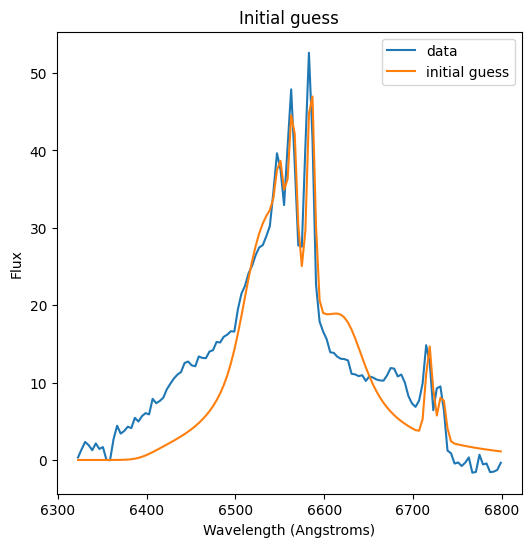

<Figure size 640x480 with 0 Axes>

In [16]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+z),flux,label='data')
plt.plot(wl/(1+z),modelguess,label='initial guess')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Initial guess')
plt.legend()
plt.show()
plt.clf()

Establish bounds for fitted parameters. These will be used to make a uniform prior.

In [17]:
angimax = 89.9
angimin= 0.1
xi1min = 100
xi1max = 2000
xi2min = 1.01
xi2max = 40
broadmin = 0
broadmax = 1000
ellmin = 0.0
ellmax=0.99
phi0min=0.0
phi0max=360.0
diskmins = [xi1min,xi2min,broadmin,angimin,ellmin,phi0min]
diskmax = [xi1max,xi2max,broadmax,angimax,ellmax,phi0max]

In [18]:
lp = likelihood.logprob_ell(wl, flux, fluxerr, lines, fixed, fitted, diskmins, diskmax)

Use scipy.optimize.minimize to find a simple solution for the fitted parameters

In [19]:
nll = lambda *args: -lp(*args)
soln = minimize(nll, initial, method='Nelder-Mead')
modelfit = lp.test(soln.x)
print('Best-fit parameter values', soln.x)

Best-fit parameter values [143.84002164  13.20225454 653.15275888  35.93491281   0.98995865
 209.25858306]


This fit succeeeded because we chose a reasonable initial guess with a high ellipticity. If we had started with a zero ellipticity guess, it would have found our old circular solution!

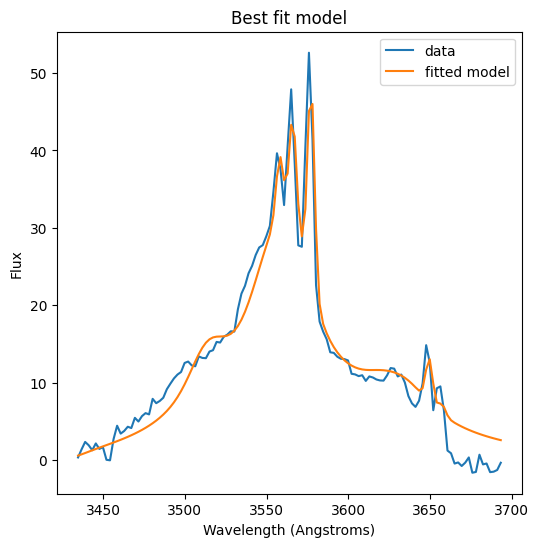

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(6,6))
plt.plot(wl/(1+soln.x[4]),flux,label='data')
plt.plot(wl/(1+soln.x[4]),modelfit,label='fitted model')
plt.xlabel('Wavelength (Angstroms)')
plt.ylabel('Flux')
plt.title('Best fit model')
plt.legend()
plt.show()
plt.clf()

Now import the emcee module to sample the parameter space, with walkers initialized around the best fit parameters from the previous step. Run the sampler for 1000 iterations and save the progress to file. 

In [21]:
import emcee
pos = soln.x + 1e-1 * soln.x * np.random.randn(20, soln.x.shape[0])
#pos = initial + 1e-1 * initial * np.random.randn(20, initial.shape[0])
nwalkers, ndim = pos.shape
filename ='ell_emcee.h5'
backend = emcee.backends.HDFBackend(filename)
#backend.reset(nwalkers, ndim)
sampler = emcee.EnsembleSampler(
        nwalkers, ndim, lp, args=(), backend=backend
    )
sampler.run_mcmc(pos, 1000, progress=True)

100%|███████████████████████████████████████| 1000/1000 [23:05<00:00,  1.39s/it]


State([[694.47596147   7.28887539 652.84049771  79.38668581   0.98842166
  207.06619404]
 [719.14681152   6.35889057 696.92419593  76.77315668   0.98992837
  209.00125182]
 [761.14680003   6.06599078 654.72093682  78.16542246   0.98873604
  208.0496827 ]
 [696.74090272   6.92992342 708.08961322  79.90191181   0.98795355
  211.23702294]
 [743.61855164   6.22688456 664.38007302  78.37744261   0.98995604
  207.68530911]
 [154.9574717   15.07214811 743.52691737  31.1913152    1.04765365
  204.43844489]
 [700.04868948   6.83892799 678.06587729  78.29231969   0.98832345
  209.45661366]
 [734.6393568    6.68495444 740.02536661  81.73698812   0.98857897
  210.74741144]
 [700.45740806   6.86677788 641.31103474  75.46106598   0.98701587
  207.10756132]
 [686.95035451   6.78795451 661.55517214  78.34325495   0.98860774
  210.84207921]
 [135.74501711  12.5516471  678.23172081  35.10068901   1.06762809
  253.90208672]
 [728.03109418   7.00688194 684.75538023  81.17598381   0.98930076
  209.11544718

Print the parameters and uncertainties found by the sampler

In [22]:
from IPython.display import display, Math
flat_samples = sampler.get_chain(discard=100, flat=True)
for i,l in enumerate(fitted_labels):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], fitted_labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

It looks like the sampler did a poor job of moving away from the zero ellipticity solution found by the minimization routine. We should start with walkers over a larger range!

Make a corner plot of the parameter samples

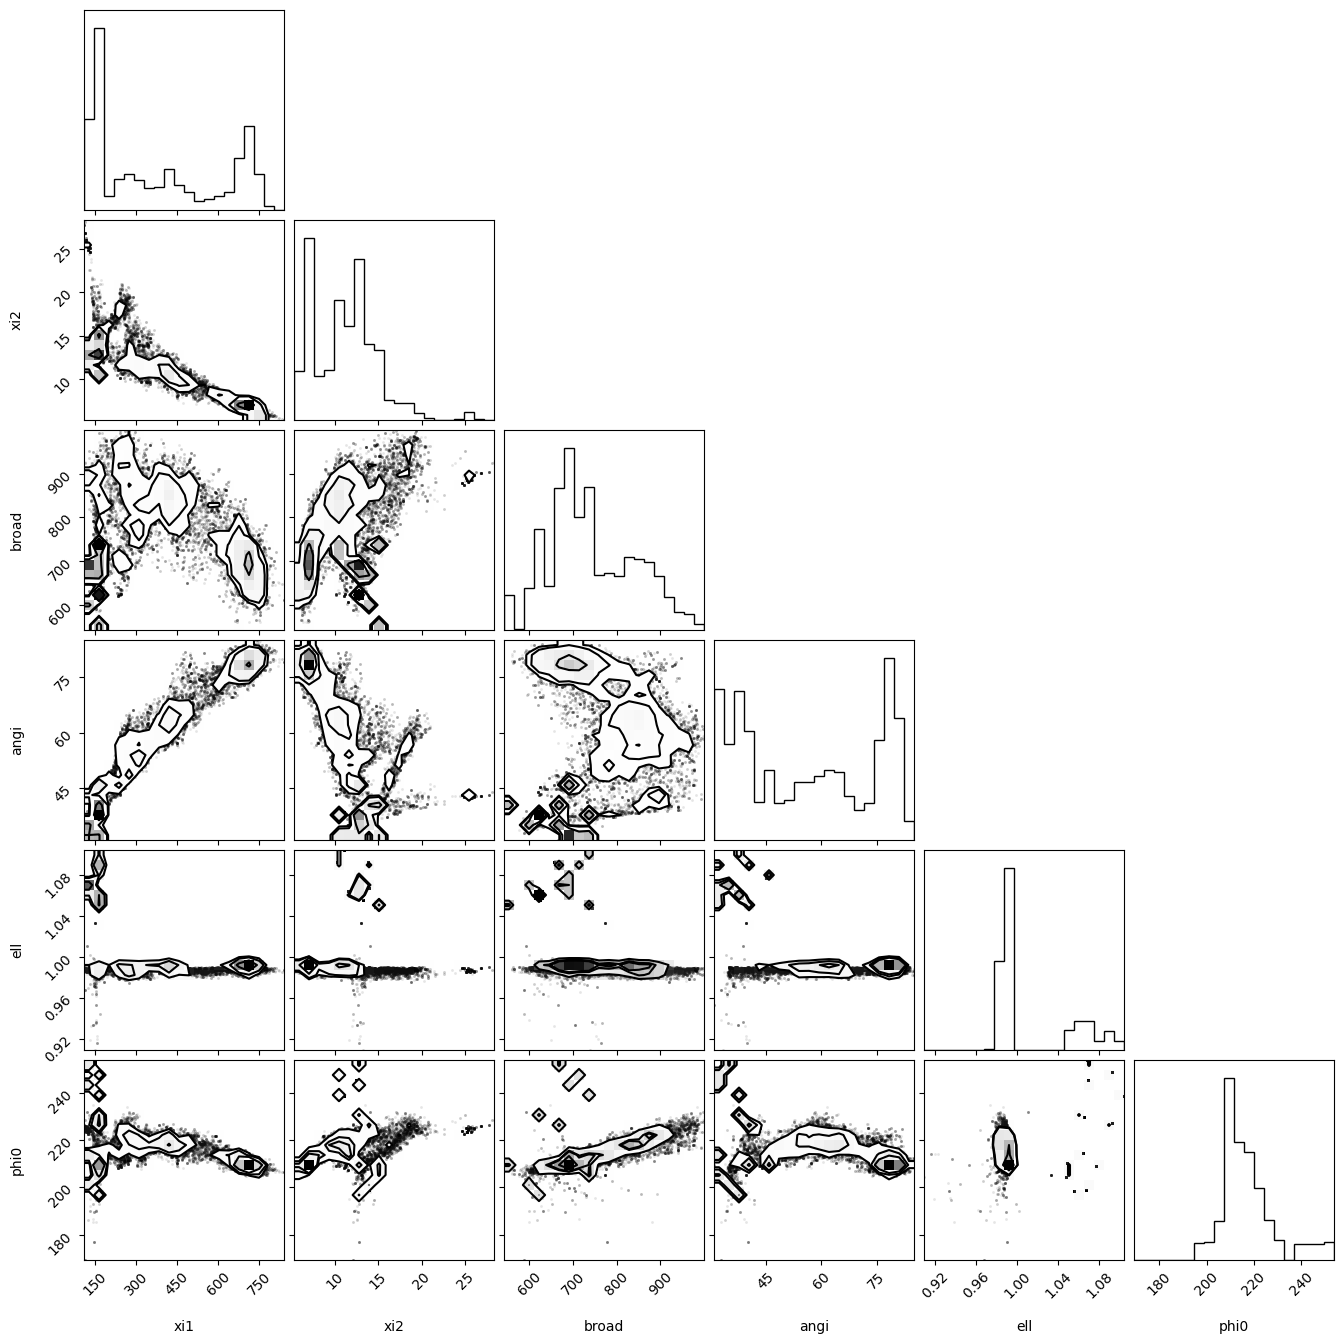

In [23]:
import corner
fig = corner.corner(
            flat_samples, labels=fitted_labels)
plt.show()

Plot the sampler chains 

<Figure size 600x600 with 0 Axes>

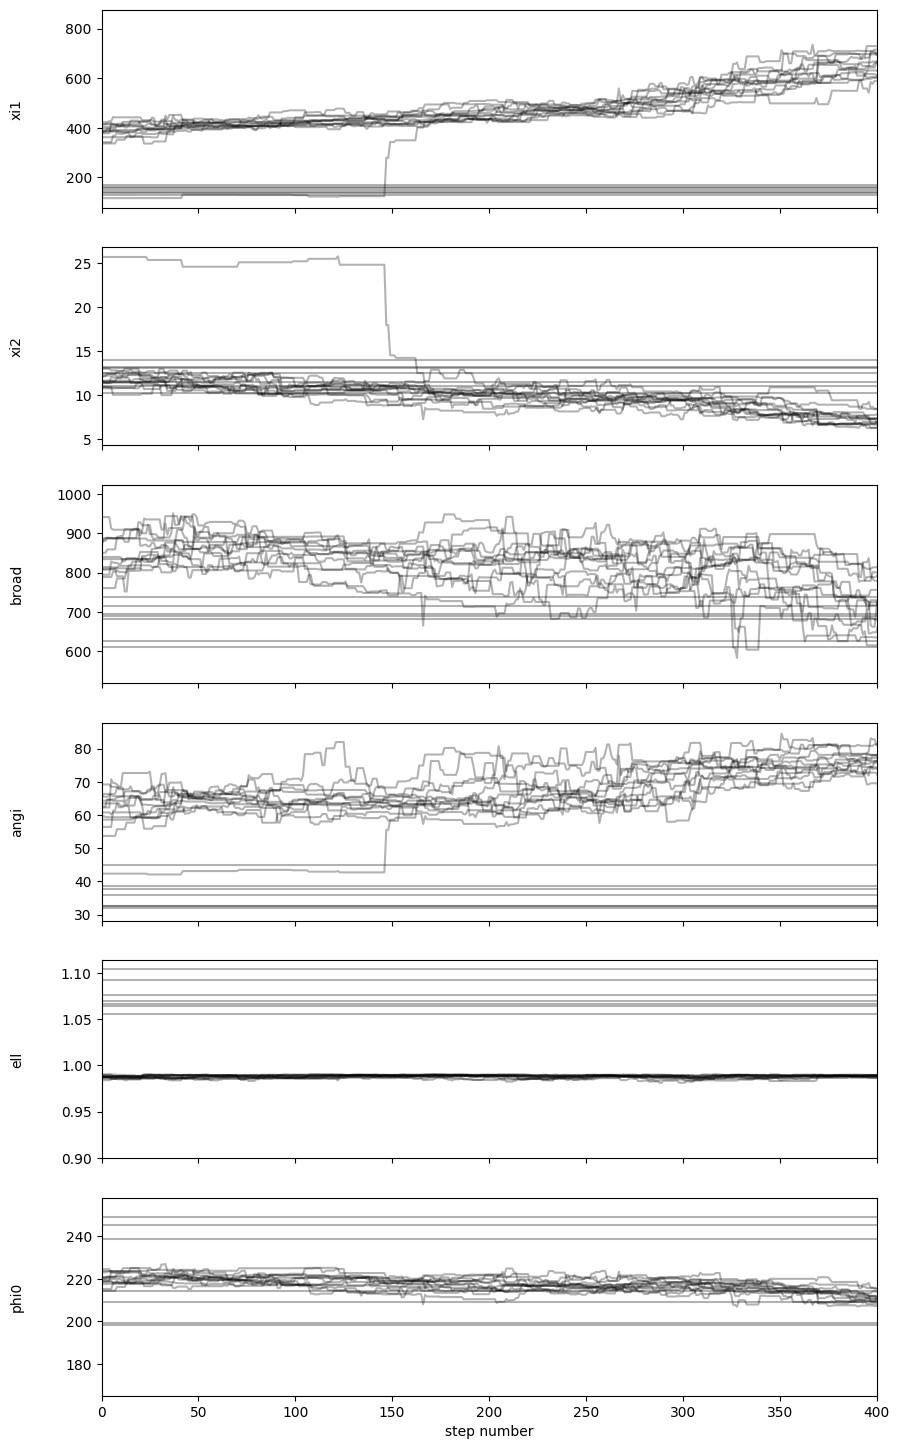

<Figure size 640x480 with 0 Axes>

In [24]:
plt.figure(figsize=(6,6))
fig, axes = plt.subplots(soln.x.shape[0], figsize=(10,3*soln.x.shape[0]), sharex=True)
samples = sampler.get_chain()
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[400:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, 400)
    ax.set_ylabel(fitted_labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
    axes[-1].set_xlabel("step number");
plt.show()
plt.clf()

We need to run the sampler for longer. Another 500 iterations should be done to see what happens.

Plot the range of good fits found by the sampler

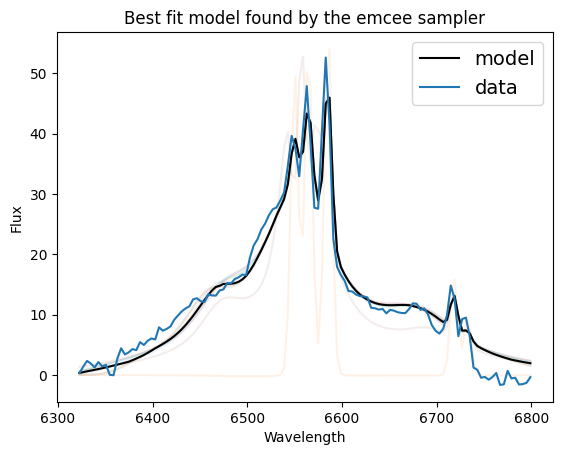

<Figure size 640x480 with 0 Axes>

In [32]:
from ultranest.plot import PredictionBand
band = PredictionBand(wl/(1+z))
inds = np.random.randint(len(flat_samples), size=10)
for ind in inds:
    sample = flat_samples[ind]
    modelfit = lp.test(sample)
    band.add(modelfit)
    plt.plot(wl/(1+z),modelfit,alpha=0.1)

band.line(color='k',label='model')
# add 1 sigma quantile
#band.shade(color='k', alpha=0.5)
# add wider quantile (0.01 .. 0.99)
#band.shade(q=0.49, color='grey', alpha=0.2);

plt.plot(wl/(1+z),flux,label='data')
plt.title('Best fit model found by the emcee sampler')
plt.legend(fontsize=14)
plt.xlabel("Wavelength")
plt.ylabel("Flux");
plt.show()
plt.clf()